##### Gather content from two external sources and have an LLM answer a question - Wikipedia and Web-Search

In [57]:
from langchain_google_genai import ChatGoogleGenerativeAI
from langchain_core.messages import SystemMessage, HumanMessage
from dotenv import load_dotenv
load_dotenv()

llm = ChatGoogleGenerativeAI(model="gemini-1.5-flash")

In [34]:
# Test Wikipedia Loader
from langchain_community.document_loaders import WikipediaLoader

docs = WikipediaLoader(query="Tarzen", load_max_docs=3).load()
docs

[Document(metadata={'title': 'Outlaw Country (2012 film)', 'summary': 'Outlaw Country is a 2012 American television film directed by Adam Arkin and Michael Dinner and starring Mary Steenburgen and John Hawkes.  It was intended to be a television pilot but the series was not picked up.\n\n', 'source': 'https://en.wikipedia.org/wiki/Outlaw_Country_(2012_film)'}, page_content="Outlaw Country is a 2012 American television film directed by Adam Arkin and Michael Dinner and starring Mary Steenburgen and John Hawkes.  It was intended to be a television pilot but the series was not picked up.\n\n\n== Premise ==\nA crime thriller and family drama set against the backdrop of southern organized crime and Nashville royalty, where music, love, hope and tragedy collide.\n\n\n== Cast ==\nMary Steenburgen as Anastasia Lee\nLuke Grimes as Eli Larkin\nHaley Bennett as Annabel Lee\nJohn Hawkes as Tarzen Larkin\nFrank Hoyt Taylor as Jackman Folcum\nJohn-Paul Howard as Jonny\nRon Prather as Sheriff Boyle\n

In [49]:
for doc in docs:
    print(doc)

page_content='Outlaw Country is a 2012 American television film directed by Adam Arkin and Michael Dinner and starring Mary Steenburgen and John Hawkes.  It was intended to be a television pilot but the series was not picked up.


== Premise ==
A crime thriller and family drama set against the backdrop of southern organized crime and Nashville royalty, where music, love, hope and tragedy collide.


== Cast ==
Mary Steenburgen as Anastasia Lee
Luke Grimes as Eli Larkin
Haley Bennett as Annabel Lee
John Hawkes as Tarzen Larkin
Frank Hoyt Taylor as Jackman Folcum
John-Paul Howard as Jonny
Ron Prather as Sheriff Boyle
Jim O'Rear as Deputy Sheriff Reese
Todd Bush as Deputy Sheriff
Johnny Whitworth as Ajax
Marc Allen as Deputy Sheriff
Bruce McKinnon as Trevor


== References ==


== External links ==
Outlaw Country at IMDb' metadata={'title': 'Outlaw Country (2012 film)', 'summary': 'Outlaw Country is a 2012 American television film directed by Adam Arkin and Michael Dinner and starring Mary

In [54]:
formatted_wiki_docs = (
    '\n\n---\n\n'.join(
        f'<Document href="{doc.metadata["source"]}">\n{doc.page_content}\n</Document>'
        for doc in docs
    )
)
print(formatted_wiki_docs)

<Document href="https://en.wikipedia.org/wiki/Outlaw_Country_(2012_film)">
Outlaw Country is a 2012 American television film directed by Adam Arkin and Michael Dinner and starring Mary Steenburgen and John Hawkes.  It was intended to be a television pilot but the series was not picked up.


== Premise ==
A crime thriller and family drama set against the backdrop of southern organized crime and Nashville royalty, where music, love, hope and tragedy collide.


== Cast ==
Mary Steenburgen as Anastasia Lee
Luke Grimes as Eli Larkin
Haley Bennett as Annabel Lee
John Hawkes as Tarzen Larkin
Frank Hoyt Taylor as Jackman Folcum
John-Paul Howard as Jonny
Ron Prather as Sheriff Boyle
Jim O'Rear as Deputy Sheriff Reese
Todd Bush as Deputy Sheriff
Johnny Whitworth as Ajax
Marc Allen as Deputy Sheriff
Bruce McKinnon as Trevor


== References ==


== External links ==
Outlaw Country at IMDb
</Document>

---

<Document href="https://en.wikipedia.org/wiki/John_Hawkes_(actor)">
John Hawkes  is an Ameri

In [14]:
# Test Tavily Search Results tool
from langchain_community.tools import TavilySearchResults

tool = TavilySearchResults(max_results=3)
result_docs = tool.invoke("Tarzen")


In [18]:
formatted_docs = "\n\n---\n\n".join(
    [
        f'<Document href="{doc["url"]}">\n{doc["content"]}\n</Document>'
        for doc in result_docs
    ]
)
print(formatted_docs)

<Document href="https://en.wikipedia.org/wiki/Tarzan_(book_series)">
Tarzan is a series of 24 adventure novels written by Edgar Rice Burroughs (1875-1950) and published between 1912 and 1966, followed by several novels either co-written by Burroughs, or officially authorized by his estate. There are also two works written by Burroughs especially for children that are not considered part of the main series. The series is considered a classic of literature and
</Document>

---

<Document href="https://en.wikipedia.org/wiki/Tarzan_(1999_film)">
Tarzan is a 1999 American animated coming-of-age [3] adventure comedy-drama film produced by Walt Disney Feature Animation and released by Walt Disney Pictures. It is based on the 1912 story Tarzan of the Apes by Edgar Rice Burroughs, being the first animated major motion picture version of the story.
</Document>

---

<Document href="https://en.wikipedia.org/wiki/Tarzan">
Tarzan is the son of a British lord and lady who were marooned on the coast 

#### Build agents

In [84]:
# Define Schema
import operator
from typing import Annotated, TypedDict

class State(TypedDict):
    question : str
    answer : str
    context : Annotated[list[str], operator.add]

In [87]:
# Tavily Agent

def web_search(state):
    
    # Search
    tavily_search = TavilySearchResults(max_results=3)
    search_docs = tavily_search.invoke(state["question"])

    # Format
    formatted_docs = "\n\n---\n\n".join(
    [
        f'<Document href="{doc["url"]}">\n{doc["content"]}\n</Document>'
        for doc in search_docs
    ])

    return {"context":[formatted_docs]}


In [88]:
# Wikipedia Agent

def wiki_search(state):
    
    # Search
    wiki_search = WikipediaLoader(state["question"],load_max_docs=3)
    search_docs = wiki_search.load()

    # Format
    formatted_wiki_docs = (
    '\n\n---\n\n'.join(
        f'<Document href="{doc.metadata["source"]}">\n{doc.page_content}\n</Document>'
        for doc in search_docs
    )
    )

    return {"context":[formatted_wiki_docs]}
    

In [81]:
# LLM node

def generate_answer(state):
    
    context = state["context"]
    question = state["question"]

    # Template
    answer_template = f"""
        Answer the following question using the provided context only,
        Question: {question}
        Context: {context}
        Answer:
    """

    # Answer
    answer = llm.invoke([
        SystemMessage(content="You are a helpful assistant."),
        HumanMessage(content=answer_template)
    ])

    return {"answer":answer}



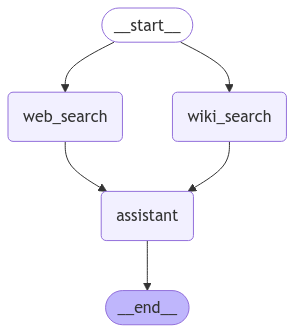

In [89]:
from langgraph.graph import StateGraph, START, END
from IPython.display import display, Image
from langgraph.checkpoint.memory import MemorySaver

builder = StateGraph(State)

builder.add_node("web_search",web_search)
builder.add_node("wiki_search",wiki_search)
builder.add_node("assistant",generate_answer)

builder.add_edge(START, "web_search")
builder.add_edge(START, "wiki_search")
builder.add_edge("web_search","assistant")
builder.add_edge("wiki_search","assistant")
builder.add_edge("assistant",END)

checkpointer = MemorySaver()

graph = builder.compile(checkpointer=checkpointer)

display(Image(graph.get_graph().draw_mermaid_png()))

In [ ]:
question = "Which is the strongest pokemon?"

thread = {
    "configurable":{
        "thread_id":"3"
    }
}

response = graph.invoke({"question":question},config=thread)


'Based on the provided text, the strongest Pokémon is a matter of debate and depends on the criteria used.  Several Pokémon are mentioned as contenders for the title of strongest, including Mewtwo (with a base stat of 780 when Mega-Evolved, tying with Mega Rayquaza and Eternamax Eternatus),  Arceus, Rayquaza, and Giratina.  The text also states that determining the strongest Pokémon involves considering stats, moves, and lore.'

In [93]:
print(response["answer"].content)

Based on the provided text, the strongest Pokémon is a matter of debate and depends on the criteria used.  Several Pokémon are mentioned as contenders for the title of strongest, including Mewtwo (with a base stat of 780 when Mega-Evolved, tying with Mega Rayquaza and Eternamax Eternatus),  Arceus, Rayquaza, and Giratina.  The text also states that determining the strongest Pokémon involves considering stats, moves, and lore.
